In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [194]:
train = pd.read_csv('input/train.csv')
test  = pd.read_csv('input/test.csv')
gender_submission = pd.read_csv('input/gender_submission.csv')

train.shape, test.shape, gender_submission.shape

((891, 12), (418, 11), (418, 2))

In [195]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 特徴量生成

In [196]:
dataset = [train, test]
for data in dataset:
    # 同乗している親族の数
    data['Family'] = data.SibSp + data.Parch
    
    # 未就学児
    # data['So_Young'] = data['Age'].apply(lambda x: x<7)
    # data['So_Young'] = data['So_Young'].map({True:1, False:0})
    
    # 同じチケットで乗船した人の数(自分以外に同じチケット番号の人が何人いるか)
    # data['Same_ticket_no'] = data.Ticket.apply(lambda x: data.Ticket.value_counts()[x] - 1)
    
    # 親族数 または 同じチケットの数の多い方を知り合いの人数として登録
    # data['Relatives'] = data.apply(lambda r: max([r['Family'], r['Relatives_tmp']]), axis=1)
    
    data['Is_free'] = data['Fare'].apply(lambda x: x==0)
    data['Is_free'] = data['Is_free'].map({True:1, False:0})
    
    # 不要となったカラムの削除
    data.drop(['SibSp', 'Parch'], inplace=True, axis=1)
    
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family,Is_free
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0,0


## 不要カラムの削除
- Embarkedは一旦残す

In [197]:
del_columns = ['PassengerId', 'Name', 'Cabin', 'Ticket', 'Fare']
train = train.drop(del_columns, axis=1)
test  = test.drop(del_columns, axis=1)

In [198]:
train.head()

,Survived,Pclass,Sex,Age,Embarked,Family,Is_free
0,0,3,male,22.0,S,1,0
1,1,1,female,38.0,C,1,0
2,1,3,female,26.0,S,0,0
3,1,1,female,35.0,S,1,0
4,0,3,male,35.0,S,0,0


## カテゴリ変数を数値に置き換える

In [199]:
dataset = [train, test]
for data in dataset:
    # 性別
    data['Sex'] = data['Sex'].map({'male': 0, 'female':1})

# 乗船港
train = pd.get_dummies(train, drop_first=True)
test  = pd.get_dummies(test,  drop_first=True)

In [200]:
train.head()

,Survived,Pclass,Sex,Age,Family,Is_free,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,0,1
1,1,1,1,38.0,1,0,0,0
2,1,3,1,26.0,0,0,0,1
3,1,1,1,35.0,1,0,0,1
4,0,3,0,35.0,0,0,0,1


In [201]:
test.head()

,Pclass,Sex,Age,Family,Is_free,Embarked_Q,Embarked_S
0,3,0,34.5,0,0,1,0
1,3,1,47.0,1,0,0,1
2,2,0,62.0,0,0,1,0
3,3,0,27.0,0,0,0,1
4,3,1,22.0,2,0,0,1


## 欠損値を埋める

In [202]:
train.isna().sum(), test.isna().sum()

(Survived        0
 Pclass          0
 Sex             0
 Age           177
 Family          0
 Is_free         0
 Embarked_Q      0
 Embarked_S      0
 dtype: int64,
 Pclass         0
 Sex            0
 Age           86
 Family         0
 Is_free        0
 Embarked_Q     0
 Embarked_S     0
 dtype: int64)

In [203]:
# 中央値で埋める
age_median = train['Age'].median()
print('Age Median:', age_median)
# fare_median = train['Fare'].median()
# print('Fare Median:', fare_median)

dataset = [train, test]
for data in dataset:
    data['Age'] = data['Age'].fillna(age_median)
    # data['Fare'] = data['Fare'].fillna(fare_median)

Age Median: 28.0


In [204]:
train.isna().sum(), test.isna().sum()

(Survived      0
 Pclass        0
 Sex           0
 Age           0
 Family        0
 Is_free       0
 Embarked_Q    0
 Embarked_S    0
 dtype: int64,
 Pclass        0
 Sex           0
 Age           0
 Family        0
 Is_free       0
 Embarked_Q    0
 Embarked_S    0
 dtype: int64)

## 訓練データとテストデータに分割

In [205]:
# 訓練用データ
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_train.head()

,Pclass,Sex,Age,Family,Is_free,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,0,1
1,1,1,38.0,1,0,0,0
2,3,1,26.0,0,0,0,1
3,1,1,35.0,1,0,0,1
4,3,0,35.0,0,0,0,1


In [206]:
# テスト用データ
X_test = test
X_test.head()

,Pclass,Sex,Age,Family,Is_free,Embarked_Q,Embarked_S
0,3,0,34.5,0,0,1,0
1,3,1,47.0,1,0,0,1
2,2,0,62.0,0,0,1,0
3,3,0,27.0,0,0,0,1
4,3,1,22.0,2,0,0,1


## モデル生成
- パイプラインとGridSearchで良いパラメータを探す

In [207]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [208]:
# パイプライン
estimator = [('scaler', MinMaxScaler()),
             ('clf', SVC())]

pipe = Pipeline(estimator)

# Grid Search
C_range = 10**np.arange(0, 6)
param = {'clf__C': C_range,
         'clf__kernel': ['rbf']}

gs = GridSearchCV(pipe, param, n_jobs=-1, verbose=10)

In [209]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   18.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   36.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('clf',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False

In [210]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'clf__C': 10, 'clf__kernel': 'rbf'},
 0.8237963718536188,
 Pipeline(memory=None,
          steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                 ('clf',
                  SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovr', degree=3,
                      gamma='scale', kernel='rbf', max_iter=-1,
                      probability=False, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False))

In [211]:
res = gs.cv_results_

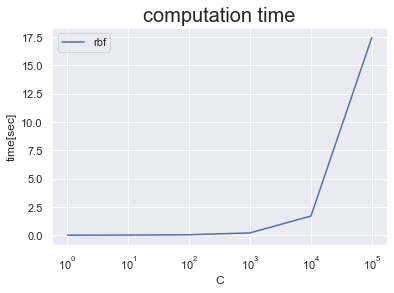

In [212]:
# 処理時間のプロット
s_rbf = (res['param_clf__kernel'] == 'rbf')
plt.plot(C_range, res['mean_fit_time'][s_rbf], label='rbf')

# s_linear = (res['param_clf__kernel'] == 'linear')
# plt.plot(C_range, res['mean_fit_time'][s_linear], label='linear')

plt.xscale('log')
plt.xlabel('C', fontsize=12)
plt.ylabel('time[sec]', fontsize=12)
plt.title('computation time', fontsize=20)
plt.legend()
plt.show()

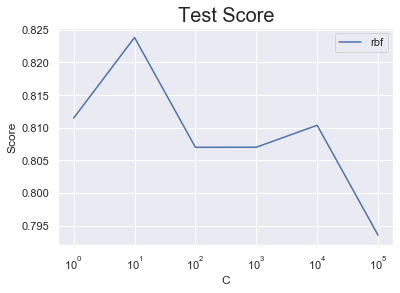

In [213]:
# 精度のプロット
plt.plot(C_range, res['mean_test_score'][s_rbf], label='rbf')
# plt.plot(C_range, res['mean_test_score'][s_linear], label='linear')

plt.legend()
plt.xscale('log')
plt.xlabel('C', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Test Score', fontsize=20)
plt.show()

## モデルの保存・ロード
- [参考Web](https://localab.jp/blog/save-and-load-machine-learning-models-in-python-with-scikit-learn/)

In [214]:
import pickle
fname = 'output/gs_trained_titanic_test.sav'

In [215]:
pickle.dump(gs, open(fname, 'wb'))

In [216]:
gs = pickle.load(open(fname, 'rb'))

## 予測の作成

In [217]:
y_pred = gs.predict(X_test)

In [218]:
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [219]:
df_result = gender_submission.copy()
df_result['Survived'] = y_pred.astype(int)
df_result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [220]:
# 予測の保存
df_result.to_csv('output/submission.csv', index=False)